In [1]:
import numpy as np
import pandas as pd
import scipy

In [2]:
from ecoevocrm.consumer_resource_system import *
from ecoevocrm.consumer_resource_system import *
import ecoevocrm.utils as utils
import ecoevocrm.viz as viz
import ecoevocrm.coarse_graining as cg
import ecoevocrm.strain_pool

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

----

## Model parameters

### Traits

In [4]:
L = 10

In [5]:
sigma = utils.binary_combinations(L, exclude_all_zeros=True)
sigma = sigma/sigma.sum(axis=1, keepdims=1)

### Costs

In [6]:
chi = 0.5

In [7]:
xi = 0.1

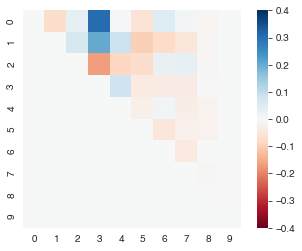

In [8]:
J = utils.random_matrix((L, L), 'tikhonov_sigmoid', args={'n_star': 5, 'delta': 1}, triangular=True, diagonal=0)
viz.matrix_plot(J, vmin=-0.4, vmax=0.4)

### Environment

In [9]:
T_total    = 1e6
T_envcycle = T_total/10

In [10]:
alpha = 0.1

theta = (2*np.pi)/T_envcycle
theta = np.random.normal(theta, theta*0.05, size=L)

phi   = (T_envcycle/L)*np.array(range(L))
phi   = phi + np.random.normal(0, 0.05*phi)

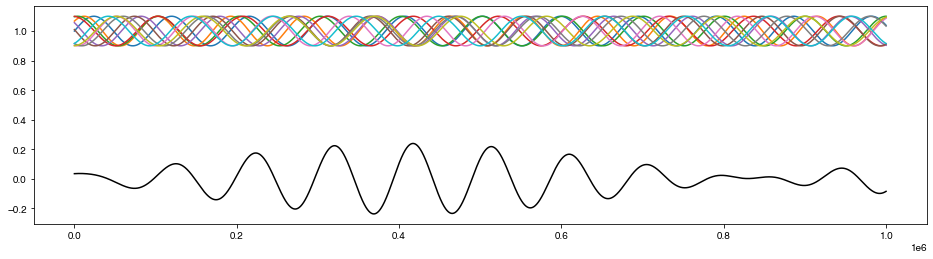

In [11]:
t = np.arange(0, T_total, 1)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
y_sum = np.zeros_like(t)
for i in range(L):
    y = 1 + (alpha * np.sin(theta[i] * (t + phi[i])))
    ax.plot(t, y) 
    y_sum += y
ax.plot(t, L - y_sum, color='k')
plt.show()

## Simulate model

In [12]:
system = ConsumerResourceSystem(type_set=TypeSet(sigma=sigma[0], xi=xi, chi=chi, J=J, binarize_traits_J_cost_terms=True, mu=1e-10), 
                                alpha=alpha, theta=theta, phi=phi, resource_influx_mode='sinusoid', 
                                convergent_lineages=False, N_init=1, R_init=1)

In [13]:
system.run(T=T_total)

<AxesSubplot:>

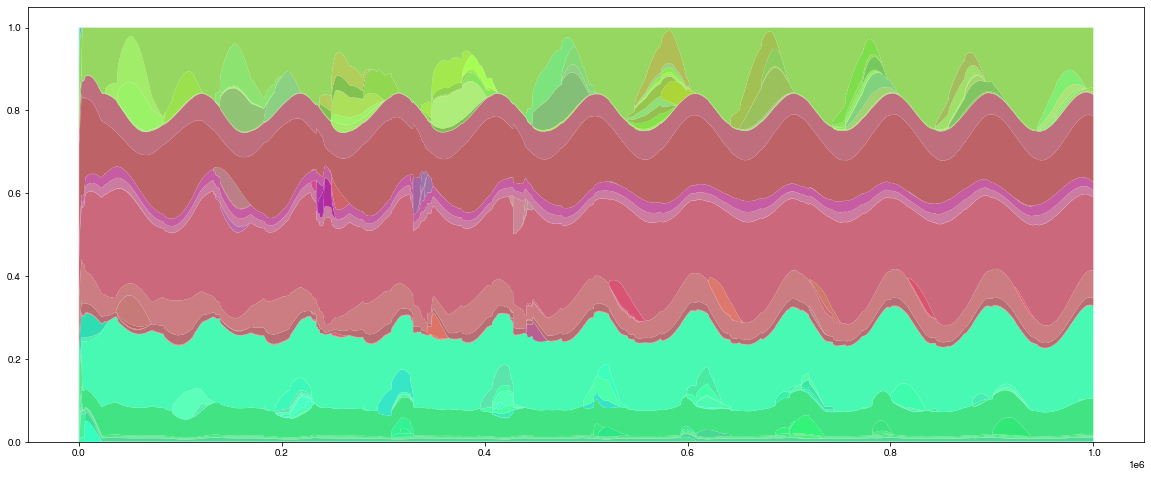

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
viz.stacked_abundance_plot(system, ax=ax, relative_abundance=True, apply_palette_depth=1, t_max=1e6, log_x_axis=False)

---------
---------

rand_cggroup: [0]
rand_cggroup: [0, 1]
rand_cggroup: [0, 1, 2]
rand_cggroup: [0, 1, 2, 3]
rand_cggroup: [0, 1, 2, 3, 4]
rand_cggroup: [0, 1, 2, 3, 4, 5]
rand_cggroup: [0, 1, 2, 3, 4, 5, 6]
rand_cggroup: [0, 1, 2, 3, 4, 5, 6, 7]
rand_cggroup: [0, 1, 2, 3, 4, 5, 6, 7, 8]
rand_cggroup: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


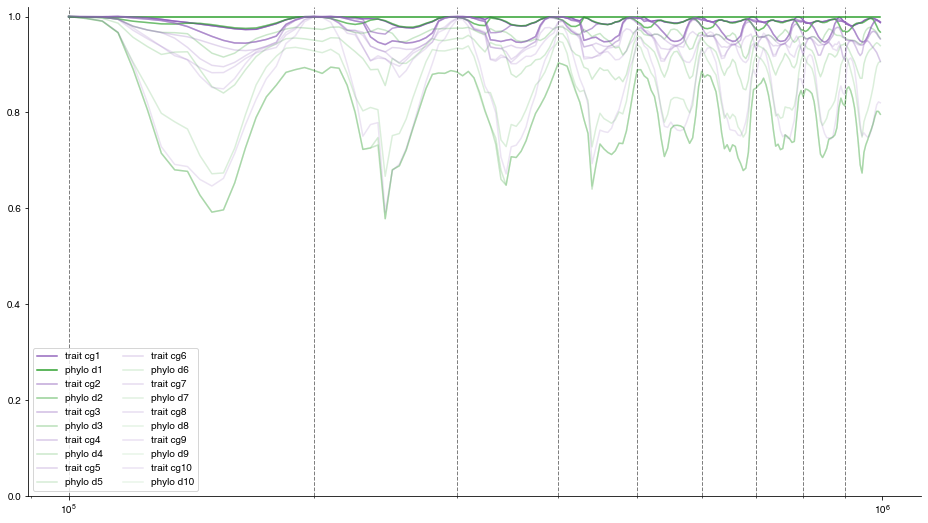

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

t0 = T_envcycle 
# t0 = get_max_diversity_t(system)

tf_vals = np.arange(0, T_total-t0, 5e3)

phylo_depths = range(1, L+1)
for d, phylo_depth in enumerate(phylo_depths):
    
    # rand_cggroup = trait_subsets[np.random.choice(range(len(trait_subsets)))]
    rand_cggroup = list(range(d+1))
    print("rand_cggroup:", rand_cggroup)
    traitgroup_persistences = []
    plot_tfs = []
    for i, tf in enumerate(tf_vals):
        if(t0+tf > T_total):
            break
        traitgroup_persistences.append( cg.functional_group_turnover(system, trait_subset=rand_cggroup, t0=t0, tf=t0+tf, inverse=True) )        
        plot_tfs.append(t0+tf)
    ax.plot(plot_tfs, traitgroup_persistences, label=f"trait cg{d+1}", color='tab:purple', alpha=1/len(rand_cggroup)**0.75)
    
    phylogroup_persistences = []
    plot_tfs = []
    for i, tf in enumerate(tf_vals):
        if(t0+tf > T_total):
            break
        phylogroup_persistences.append( cg.phylogenetic_group_turnover(system, phylogeny_depth=phylo_depth, t0=t0, tf=t0+tf, inverse=True) )
        plot_tfs.append(t0+tf)
    ax.plot(plot_tfs, phylogroup_persistences, label=f"phylo d{phylo_depth}", color='tab:green', alpha=1/(d+1))
        
# ax.axvline(T_envcycle, color='k', ls='--', lw=1, zorder=-1)
for j in range(int(T_total/T_envcycle)):
    ax.axvline(j*T_envcycle, color='k', alpha=0.5, ls='--', lw=1, zorder=-1)
    
ax.set_xscale('log')
ax.set_ylim(0, 1.02)
# ax.axhline(0)
ax.legend(ncol=2)
sns.despine()

--------
-------